In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.compose import make_column_transformer

from tensorflow.keras import layers
from tensorflow import keras

import shap

## Load Data

In [2]:
path_central_novice = r'C:\Users\imnku\Documents\Data Analysis\AMQ\CentralR-N'
all_files_central_novice = glob.glob(os.path.join(path_central_novice, "*.json"))

central_novice = pd.concat((pd.read_json(f) for f in all_files_central_novice), ignore_index=True)

path_east_novice = r'C:\Users\imnku\Documents\Data Analysis\AMQ\EastR-N'
all_files_east_novice = glob.glob(os.path.join(path_east_novice, "*.json"))

east_novice = pd.concat((pd.read_json(f) for f in all_files_east_novice), ignore_index=True)

novice = pd.concat(([central_novice, east_novice]), ignore_index=True)
novice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gameMode       900 non-null    object 
 1   name           900 non-null    object 
 2   artist         900 non-null    object 
 3   anime          900 non-null    object 
 4   annId          900 non-null    int64  
 5   songNumber     900 non-null    int64  
 6   activePlayers  900 non-null    int64  
 7   totalPlayers   900 non-null    int64  
 8   type           900 non-null    object 
 9   urls           900 non-null    object 
 10  siteIds        900 non-null    object 
 11  difficulty     900 non-null    float64
 12  animeType      900 non-null    object 
 13  animeScore     900 non-null    float64
 14  vintage        900 non-null    object 
 15  tags           900 non-null    object 
 16  genre          900 non-null    object 
 17  altAnswers     900 non-null    object 
 18  startSampl

## Data cleaning

In [3]:
novice['correct'] = novice['correct'].astype(np.bool_)

In [4]:
X = novice.drop(['annId', 'urls', 'siteIds', 'animeScore', 'altAnswers', 'fromList', 'gameMode', 'selfAnswer'], axis=1).copy()
X = X.dropna()
y = X.pop('correct')

def find_gt(players):
    player = [x for x in players if x['name'] == 'TrueXC'][0]
    if 'guessTime' in player:
        gt = player['guessTime']
    else:
        gt = 20
    return gt

X['samplePercent'] = X['startSample']/X['videoLength']
X['type_noNumber'] = X['type'].str.split().str[0]
X['AiredYear'] = X['vintage'].str.split().str[1].astype(int)
# X['guessTime'] = X['players'].apply(find_gt)

X = X.drop(['name', 'artist', 'anime', 'songNumber', 'activePlayers', 'totalPlayers', 'type', 'vintage',
            'startSample', 'videoLength', 'players'], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 896 entries, 0 to 899
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   difficulty     896 non-null    float64
 1   animeType      896 non-null    object 
 2   tags           896 non-null    object 
 3   genre          896 non-null    object 
 4   samplePercent  896 non-null    float64
 5   type_noNumber  896 non-null    object 
 6   AiredYear      896 non-null    int32  
dtypes: float64(2), int32(1), object(4)
memory usage: 52.5+ KB


## Data preprocessing

In [5]:
data_list = ['tags', 'genre']
data_num = ['difficulty', 'samplePercent', 'AiredYear']
data_cat = ['animeType', 'type_noNumber']

mlb = MultiLabelBinarizer()
s = X['tags']
dummy = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=X.index)
X = pd.concat([X, dummy], axis=1)

s = X['genre']
dummy = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=X.index)
X = pd.concat([X, dummy], axis=1)

X = X.drop(['tags', 'genre'], axis=1)

X = pd.get_dummies(X, columns=data_cat)

scaler = StandardScaler()
s = X[data_num]
dummy = pd.DataFrame(scaler.fit_transform(s), columns=s.columns, index=X.index)
X = X.drop(data_num, axis=1)
X = pd.concat([X, dummy], axis=1)

preproc = make_column_transformer(
    (OneHotEncoder(), data_cat),
    (StandardScaler(), data_num), remainder='passthrough')


X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, random_state=1)
#X_train = preproc.fit_transform(X_train)
#X_valid = preproc.transform(X_valid)

## Define and train a neural network

In [6]:
nn = keras.Sequential([
    layers.Dense(16, input_shape=[X_train.shape[1]], activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

nn.compile('adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True,
)

history = nn.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=16,
    epochs=50,
    callbacks=[early_stopping],
)

Epoch 1/50
42/42 [==============================] - 1s 6ms/step - loss: 0.6759 - binary_accuracy: 0.6280 - val_loss: 0.6298 - val_binary_accuracy: 0.6964
Epoch 2/50
42/42 [==============================] - 0s 2ms/step - loss: 0.6126 - binary_accuracy: 0.6324 - val_loss: 0.5380 - val_binary_accuracy: 0.6964
Epoch 3/50
42/42 [==============================] - 0s 2ms/step - loss: 0.5431 - binary_accuracy: 0.6830 - val_loss: 0.4896 - val_binary_accuracy: 0.7812
Epoch 4/50
42/42 [==============================] - 0s 2ms/step - loss: 0.4500 - binary_accuracy: 0.8021 - val_loss: 0.4690 - val_binary_accuracy: 0.7857
Epoch 5/50
42/42 [==============================] - 0s 2ms/step - loss: 0.3775 - binary_accuracy: 0.8333 - val_loss: 0.4770 - val_binary_accuracy: 0.7723
Epoch 6/50
42/42 [==============================] - 0s 2ms/step - loss: 0.3200 - binary_accuracy: 0.8616 - val_loss: 0.4949 - val_binary_accuracy: 0.7812
Epoch 7/50
42/42 [==============================] - 0s 2ms/step - loss: 0.27

<AxesSubplot: title={'center': 'Accuracy'}>

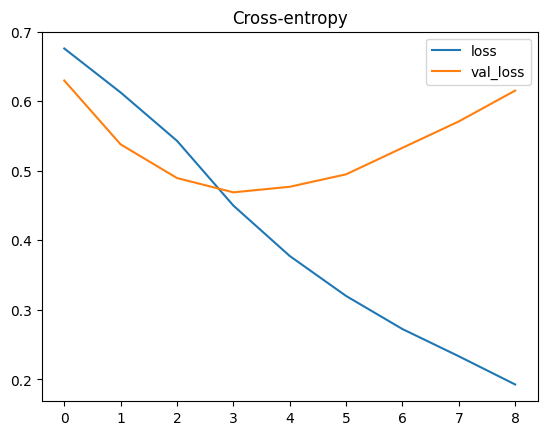

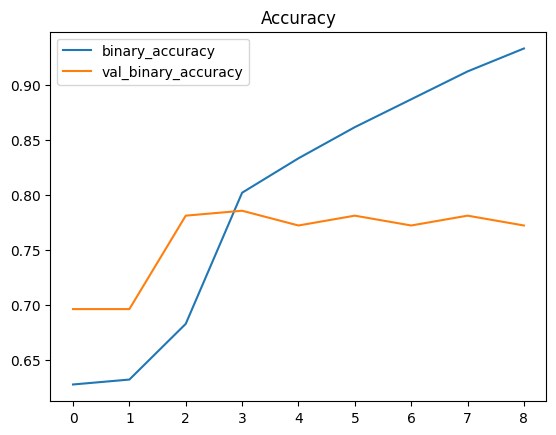

In [7]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [8]:
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                4752      
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,585
Trainable params: 5,585
Non-trainable params: 0
_________________________________________________________________


In [9]:
pred = np.array(nn.predict(X_valid))
pred = pd.Series(pred.flatten(), index=y_valid.index)
false_val = pred.loc[pred < 0.5] # Model predicts miss

a = np.array(false_val.index)
b = np.array(y_valid[y_valid < 0.5].index) # Actual miss
diff = np.setdiff1d(a, b) # Model misses - actual misses = Things the network thinks you will miss but you didn't miss
pred.describe()

7/7 [==============================] - 0s 1ms/step


count    224.000000
mean       0.670136
std        0.247992
min        0.236505
25%        0.424305
50%        0.723546
75%        0.906938
max        0.995325
dtype: float64

In [10]:
novice.drop(['annId', 'urls', 'siteIds', 'animeScore', 'altAnswers', 'fromList', 'gameMode', 'selfAnswer', 'players'], axis=1).iloc[diff]

,name,artist,anime,songNumber,activePlayers,totalPlayers,type,difficulty,animeType,vintage,tags,genre,startSample,videoLength,correct
17,Shooting Star,KOTOKO,"{'english': 'Please Teacher!', 'romaji': 'Oneg...",18,235,241,Opening 1,31.1,TV,Fall 2001,"[Male Protagonist, Coming of Age, Ensemble Cas...","[Comedy, Drama, Romance, Sci-Fi]",42,99.19,True
59,Starry Wish,Inori Minase,"{'english': 'ViVid Strike!', 'romaji': 'ViVid ...",15,223,228,Ending 1,28.0,TV,Fall 2016,"[Magic, Martial Arts, Yuri, Primarily Female C...","[Action, Drama, Mahou Shoujo, Sports]",2,89.04,True
177,Flop Around,"Miku Itou, Ayana Taketatsu","{'english': 'Love Flops', 'romaji': 'Renai Flo...",43,228,243,Ending 2,32.2,TV,Fall 2022,"[Harem, Parody, Male Protagonist, Tragedy, Pri...","[Comedy, Ecchi, Romance, Sci-Fi]",23,89.45,True
216,Waga Tomo Mazinger Z,Ichiro Mizuki,"{'english': 'Mazinger Z', 'romaji': 'Mazinger Z'}",37,225,236,Insert Song,42.9,TV,Fall 1972,"[Shounen, Male Protagonist, Primarily Male Cas...","[Action, Drama, Mecha, Sci-Fi]",102,142.18,True
241,ANATATO,LUVRAW,"{'english': 'Space☆Dandy', 'romaji': 'Space☆Da...",17,231,235,Insert Song,39.9,TV,Winter 2014,"[Parody, Space, Male Protagonist, Primarily Ma...","[Comedy, Sci-Fi]",27,76.03,True
258,Yappari Economy,YABI×YABI,"{'english': 'Saving 80,000 Gold in Another Wor...",34,239,246,Ending 1,30.9,TV,Winter 2023,"[Military, Female Protagonist, Guns, Isekai, E...",[Fantasy],12,89.09,True
301,Mitsubachi Maaya no Bouken,Chiita to Mitsubachi Gasshou-dan,"{'english': 'Maya the Honey Bee', 'romaji': 'M...",32,226,238,Opening 1,27.0,TV,Spring 1975,"[Kids, Educational, Classic Literature, Outdoo...","[Adventure, Comedy]",18,66.77,True
311,LIGHTS,Aimi,{'english': 'How a Realist Hero Rebuilt the Ki...,42,226,239,Ending 1,23.6,TV,Winter 2022,"[Harem, Male Protagonist, Time Manipulation, P...","[Action, Adventure, Fantasy, Romance]",11,84.36,True
344,Mitsubachi Maaya no Bouken,Chiita to Mitsubachi Gasshou-dan,"{'english': 'Maya the Honey Bee', 'romaji': 'M...",30,233,250,Opening 1,28.1,TV,Spring 1975,"[Kids, Educational, Classic Literature, Outdoo...","[Adventure, Comedy]",20,66.77,True
382,orion,Kenshi Yonezu,"{'english': 'March comes in like a lion', 'rom...",23,221,230,Ending 3,41.8,TV,Fall 2016,"[Seinen, Male Protagonist, Tragedy, Family Lif...","[Drama, Slice of Life]",49,89.57,True


In [11]:
row = X_valid.iloc[201]

explainer = shap.KernelExplainer(nn, X_train)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], row)

Using 672 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [12]:
novice.drop(['annId', 'urls', 'siteIds', 'animeScore', 'altAnswers', 'fromList', 'gameMode', 'selfAnswer', 'players', 'activePlayers', 'totalPlayers'], axis=1).iloc[row.name]

name                                                 lost in you
artist                                        Megumi Hayashibara
anime          {'english': 'Invincible King Tri-Zenon', 'roma...
songNumber                                                    12
type                                                    Ending 1
difficulty                                                  11.7
animeType                                                     TV
vintage                                                Fall 2000
tags                                    [Slapstick, Super Robot]
genre                                            [Mecha, Sci-Fi]
startSample                                                   36
videoLength                                                88.68
correct                                                    False
Name: 731, dtype: object